The presentation video for the paper reading task is available here : https://drive.google.com/file/d/1j2prLcwfz-OgbyFZimF4dTwGiNdVCzDw/view?usp=sharing

The node2vec algorithm has been the recurring theme of this assignment. It was mentioned in both the paper reading task as well as the link prediction task. I decided to have the node embeddings of the graph datasets calculated and ready for use in other tasks. I am starting by importing the packages and loading the edge_list and node_list in the cell below.

(implementation by PyG: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.Node2Vec.html, paper: https://arxiv.org/abs/1607.00653)

In [1]:
import torch
from torch_geometric.nn.models import Node2Vec
import networkx as nx
import matplotlib.pyplot as plt

edges_countries_tensor = torch.load('data/pt/countries_fully_connected_edges.pt').t()
edges_cities_tensor = torch.load('data/pt/cities_fully_connected_edges.pt').t()
edges_combined_tensor = torch.load('data/pt/combined_fully_connected_edges.pt').t()

nodes_countries_tensor = edges_countries_tensor.clone().flatten().unique()
nodes_cities_tensor = edges_countries_tensor.clone().flatten().unique()
nodes_combined_tensor = edges_countries_tensor.clone().flatten().unique()

From gephi I generated the graph distance and degree report for the countries, cities and combined datasets. I think the notable properties here are:

||Countries|Cities|Combined|
|-|-|-|-|
|Avg. Degree|10.6|20.9|31.7|
|Diameter|7|5|5|
|Avg. Path Length|3|2.8|2.5|

For node2vec, I intend to use the average degree value as number of walks per node, diameter value as walk length and average path length as context size (more precisely their floor values). They are in html format and available in the data/reports/ folder. The screenshot of the graph distance report for countries dataset is in the cell below.

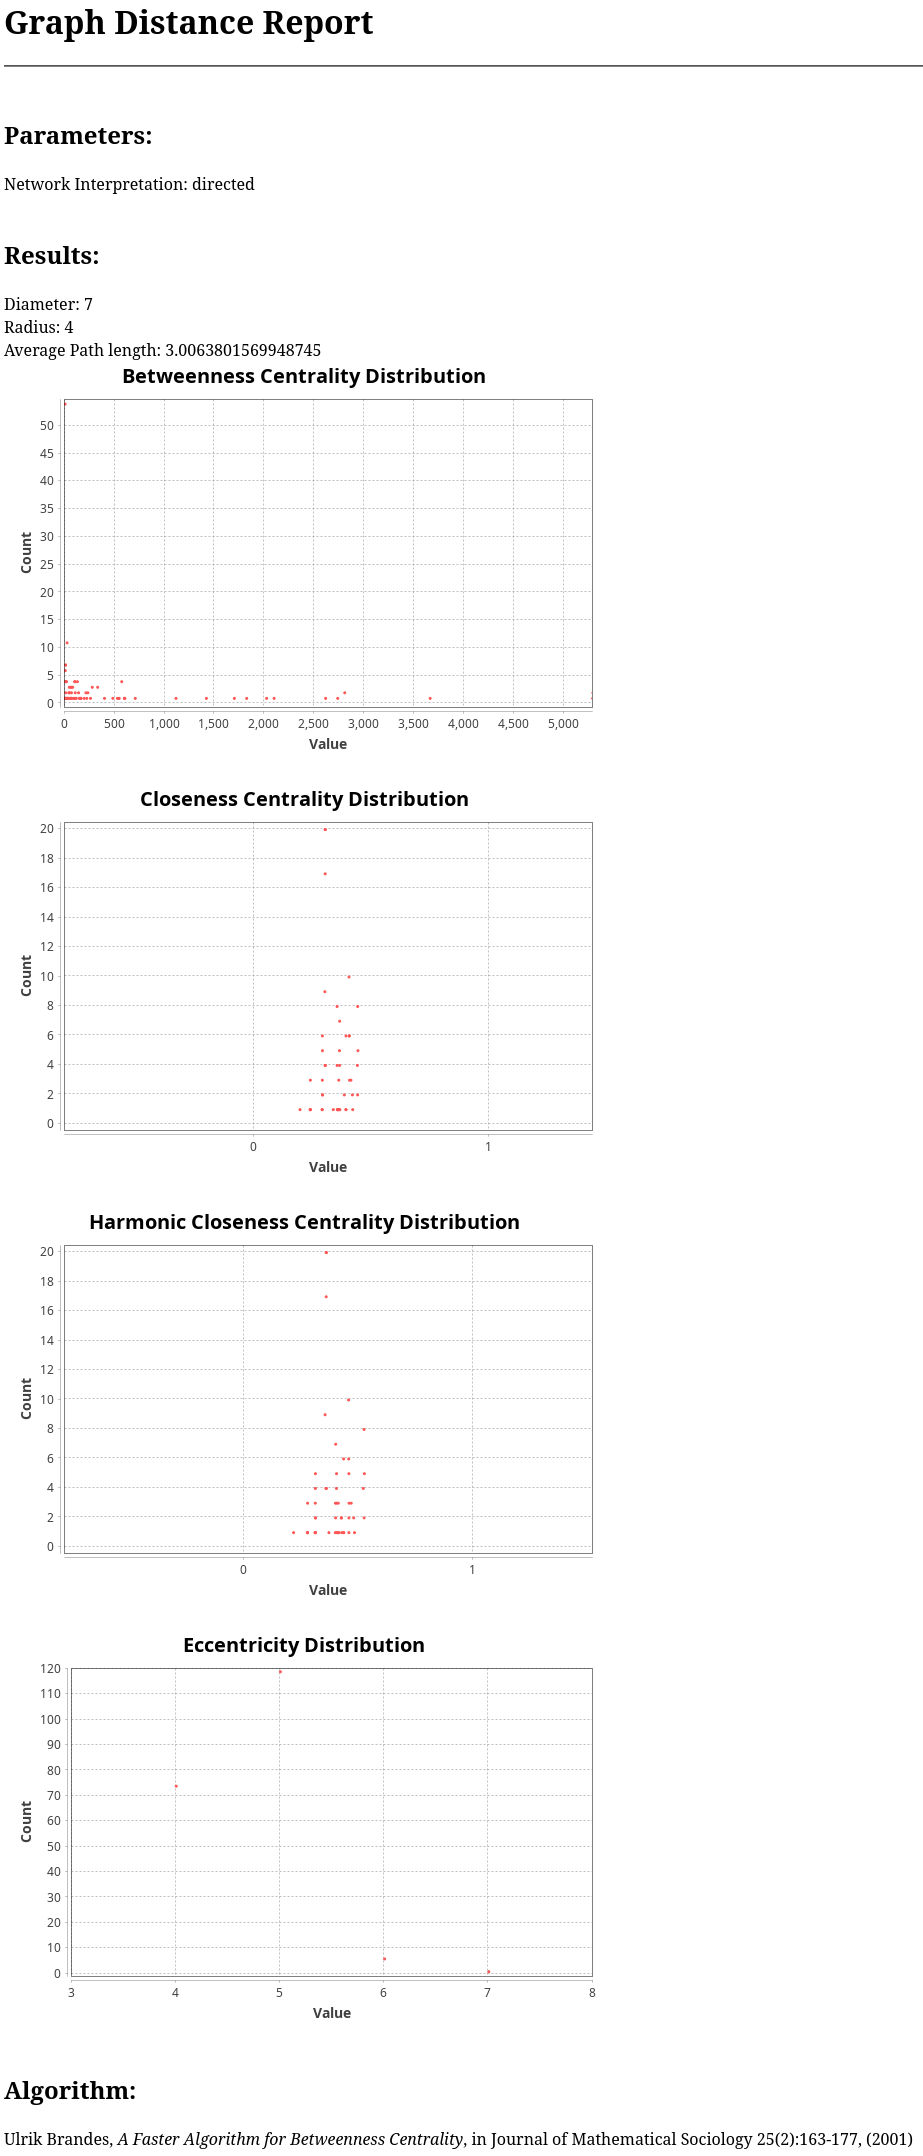

In [2]:
from IPython.display import Image

Image(filename="data/png/graph_distance_report_countries.png", width=500)

I will be defining a function to return the required model in the cell below. I have 3 datasets (countries, cities and combined) and I can run node2vec using 3 different strategies (fixed random aka deepwalk (https://arxiv.org/abs/1403.6652), BFS or DFS). And the provides me with 3 times 3 equals 9 combinations of embeddings for downstream use cases. The model design in the cell below and the training in the cell that follows are inspired from the node2vec example provided by PyG (https://github.com/pyg-team/pytorch_geometric/blob/master/examples/node2vec.py).

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model(p,q,edges,avg_degree, diameter, avg_path_length,emb_size=128):
    model = Node2Vec(
        edges, 
        embedding_dim=emb_size, 
        walk_length=diameter,#20, 
        context_size=avg_path_length,#10, 
        walks_per_node=avg_degree,#10, 
        # num_negative_samples=1, 
        p=p, 
        q=q, 
        # sparse=True
    ).to(device)
    return model

models = {
    'node2vec_countries_dw': get_model(1.0,1.0,edges_countries_tensor,10,7,3,8),
    'node2vec_countries_bfs': get_model(1.0,0.5,edges_countries_tensor,10,7,3,8),
    'node2vec_countries_dfs': get_model(1.0,2.0,edges_countries_tensor,10,7,3,8),
    'node2vec_cities_dw': get_model(1.0,1.0,edges_cities_tensor,20,5,2,32),
    'node2vec_cities_bfs': get_model(1.0,0.5,edges_cities_tensor,20,5,2,32),
    'node2vec_cities_dfs': get_model(1.0,2.0,edges_cities_tensor,20,5,2,32),
    'node2vec_combined_dw': get_model(1.0,1.0,edges_combined_tensor,31,5,2,64),
    'node2vec_combined_bfs': get_model(1.0,0.5,edges_combined_tensor,31,5,2,64),
    'node2vec_combined_dfs': get_model(1.0,2.0,edges_combined_tensor,31,5,2,64)
}

I chose a the embedding sizes 8, 32 and 64 for the countries, cities and combined data respectively. For each of the 9 models I will be plotting the value of loss function with respect to the training epochs.  I believe the convergence would be achieved roughly around 100 epochs. In the example by PyG, 100 epochs were used, but I have decided to run it for 200 epochs to see how the losses trend follows after 100 epochs.

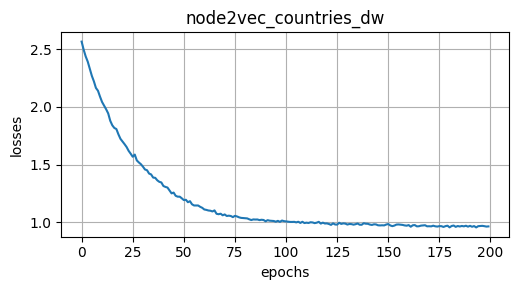

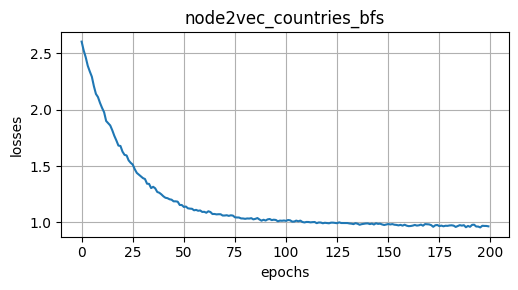

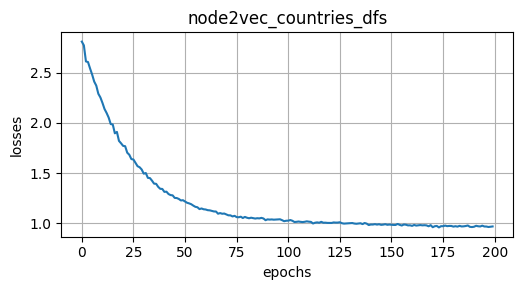

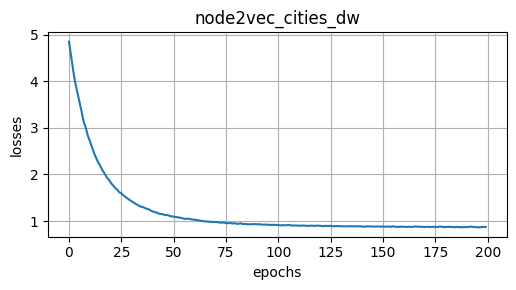

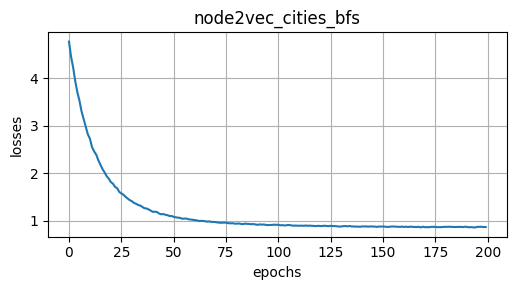

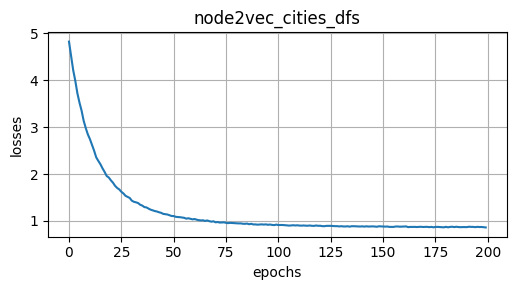

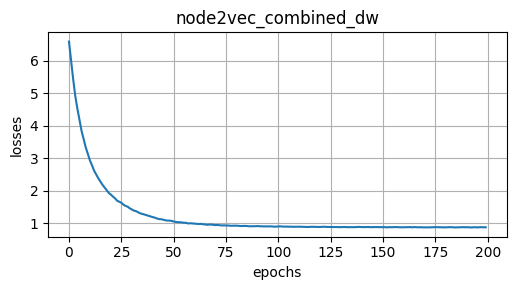

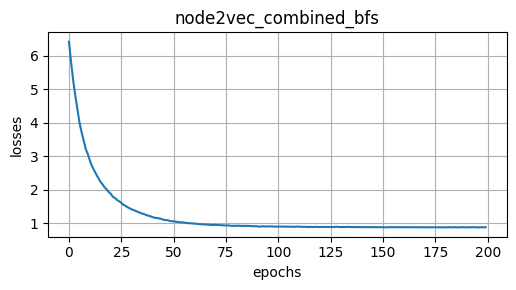

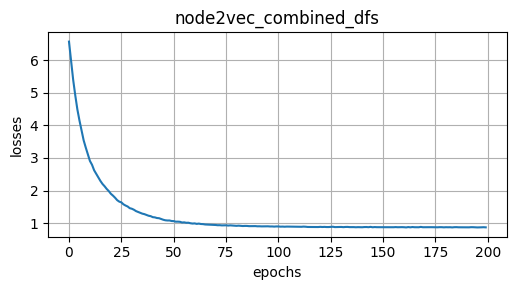

In [4]:
for model_name in models:
    model = models[model_name]
    num_workers = 4
    loader = model.loader(batch_size=128, shuffle=True, num_workers=num_workers)
    # optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    def train():
        model.train()
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(loader)

    losses = []
    for epoch in range(1, 201):
        loss = train()
        losses.append(loss)
        # if epoch%10==0: print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

    emb = model()
    torch.save(emb,'data/emb/'+str(model_name)+'.pt')
    
    fig = plt.figure(figsize=(10,3))
    fig.clf()

    ax = fig.add_subplot(1,2,1)
    ax.plot(losses)
    ax.set_title(model_name)
    ax.set_xlabel('epochs')
    ax.set_ylabel('losses')
    ax.grid(True)

    fig.tight_layout()
    